In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from models import Pyt_Attention_Xformer as Xformer
from sklearn.manifold import TSNE
import numpy as np
import torch

In [2]:
## Device toggle
device = torch.device("mps")
# device = torch.device("cpu")

In [3]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
vocab_size = len(vocab) + 1 # Blank token
block_length = max_length + 1
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [4]:
# ## Hyperparameters
emb_dim = 64
num_heads = 4
dropout = 0.2

In [10]:
# Set up optimizer and model
batch_size = 512
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(emb_dim, vocab_size, num_heads, dropout).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

Text(0, 0.5, 'Loss')

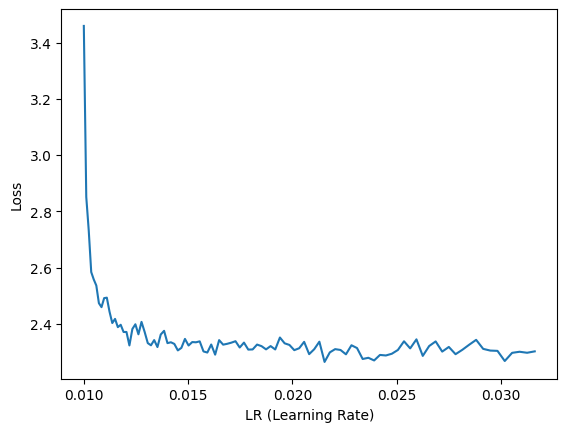

In [11]:
# ## Optimal lr sweep
import matplotlib.pyplot as plt
num_epochs = 100
lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -2, -1.5)
plt.plot(lri, lossi)
# Add labels to the x-axis and y-axis
plt.xlabel('LR (Learning Rate)')
plt.ylabel('Loss')

In [ ]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [ ]:
# Training loop 
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

In [ ]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss[10:], label='Training Loss')
plt.plot(te_loss[10:], label='Testing Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [ ]:
## Pretty print the samples
print_samples(model, train_data, max_length, device, num=32)

In [ ]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=7)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')